In [161]:
mycorpus<-read.csv("prova.csv",header=TRUE, sep=";",stringsAsFactors = FALSE) 

In [162]:
library(tm)

In [163]:
corpus<-Corpus(VectorSource(mycorpus$Abstract))

In [164]:
corpus

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 1465

In [165]:
cleancorpus<-tm_map(corpus,content_transformer(removePunctuation))
cleancorpus<-tm_map(cleancorpus,content_transformer(removeNumbers))
cleancorpus<-tm_map(cleancorpus,content_transformer(tolower))
cleancorpus<-tm_map(cleancorpus,content_transformer(function(x) removeWords(x,stopwords(kind="en"))))

In [166]:
cleancorpus


<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 1465

In [167]:
tdm<-DocumentTermMatrix(cleancorpus)

In [168]:
tdm

<<DocumentTermMatrix (documents: 1465, terms: 12215)>>
Non-/sparse entries: 90718/17804257
Sparsity           : 99%
Maximal term length: 31
Weighting          : term frequency (tf)

In [169]:
#weith with tfidf
tdm2 <- as.DocumentTermMatrix(tdm,weighting=weightTfIdf)

#selected of terms based on frequences
tdm<-tdm2[apply(tdm2,1,sum)>9,]

In [170]:
tdm

<<DocumentTermMatrix (documents: 1465, terms: 12215)>>
Non-/sparse entries: 90718/17804257
Sparsity           : 99%
Maximal term length: 31
Weighting          : term frequency (tf)

In [171]:
# install.packages("topicmodels", repos='http://cran.us.r-project.org')

In [199]:
library(topicmodels)
lda <- LDA(tdm, k = 50) # find 20 topics

In [200]:
str(lda)

Formal class 'LDA_VEM' [package "topicmodels"] with 14 slots
  ..@ alpha          : num 0.00977
  ..@ call           : language LDA(x = tdm, k = 50)
  ..@ Dim            : int [1:2] 1465 12215
  ..@ control        :Formal class 'LDA_VEMcontrol' [package "topicmodels"] with 13 slots
  .. .. ..@ estimate.alpha: logi TRUE
  .. .. ..@ alpha         : num 1
  .. .. ..@ seed          : int 1470477226
  .. .. ..@ verbose       : int 0
  .. .. ..@ prefix        : chr "C:\\Users\\Martin\\AppData\\Local\\Temp\\Rtmp6B2H6u\\file1cf421058c2"
  .. .. ..@ save          : int 0
  .. .. ..@ nstart        : int 1
  .. .. ..@ best          : logi TRUE
  .. .. ..@ keep          : int 0
  .. .. ..@ estimate.beta : logi TRUE
  .. .. ..@ var           :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. .. ..@ iter.max: int 500
  .. .. .. .. ..@ tol     : num 1e-06
  .. .. ..@ em            :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. .. ..@ iter.max: int 1

In [202]:
terms_10 <- terms(lda, 10) # first 10 terms of every topic
terms_10 <- apply(terms_10, MARGIN = 2, paste, collapse = ", ")

In [230]:
topic_most_likely <- topics(lda, 1)

In [231]:
topics_years <- data.frame(date=(mycorpus$anno),topic_most_likely)

In [205]:
library(ggplot2)

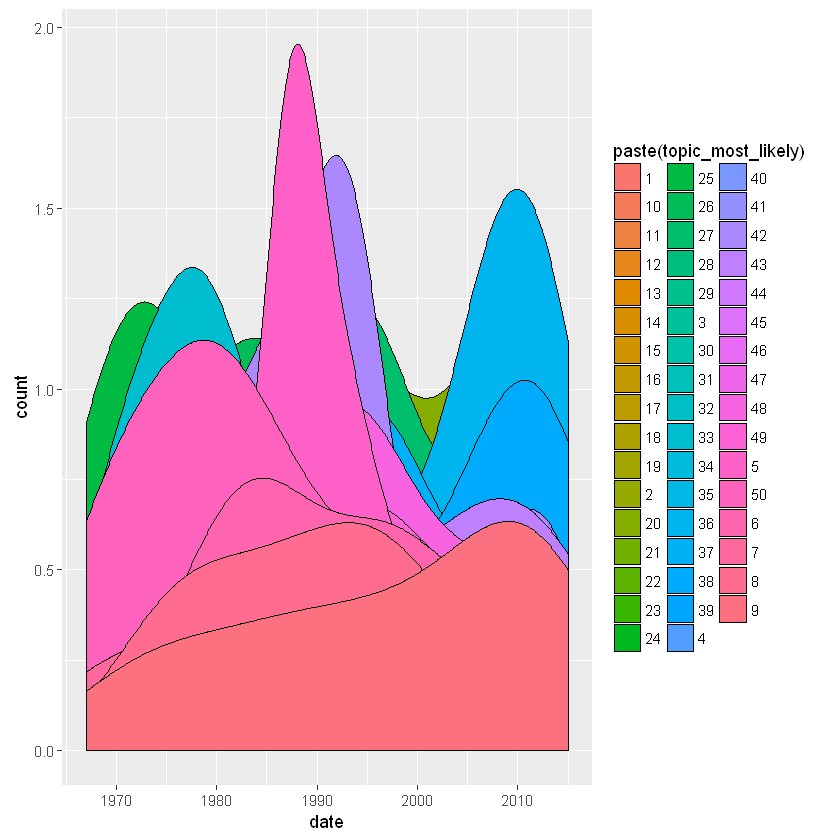

In [282]:
#qplot(date, ..count.., data=topics_years, geom="density", fill=terms_10[topic_most_likely])
qplot(date, ..count.., data=topics_years, geom="density", fill=paste(topic_most_likely))


In [ ]:
# I find ggplot more explicit (a commenter on StackOverflow said: "ignore qplot..."):

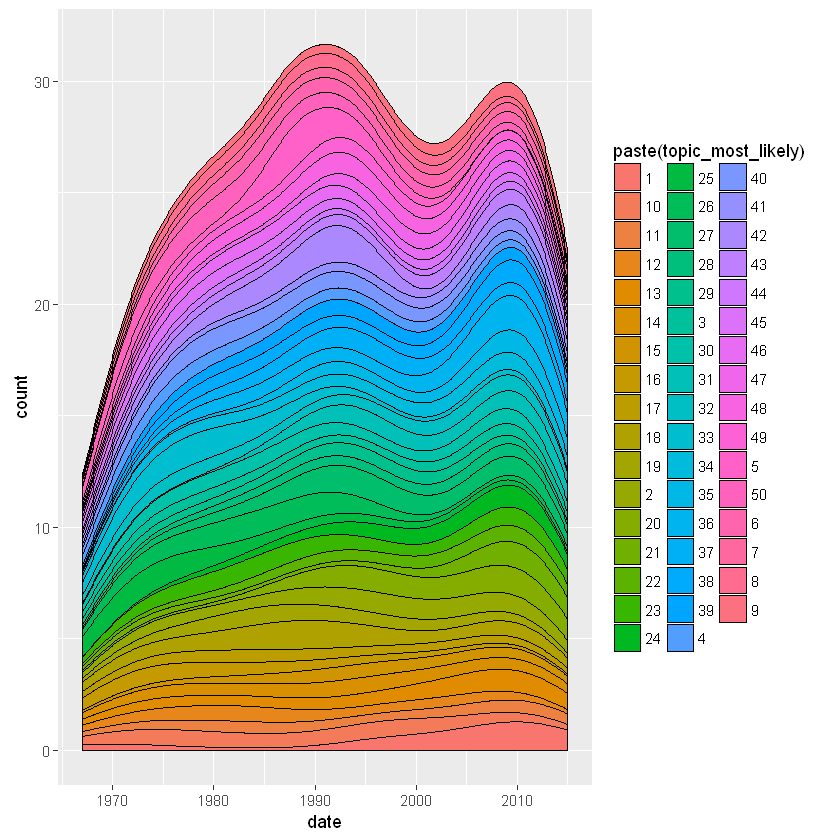

In [237]:
ggplot(topics_years, aes(x=date, y=..count..)) + 
  geom_density(aes(fill=paste(topic_most_likely)), position="stack")

In [208]:
table(mycorpus$anno)


1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 
  17   17   22   20   31   28   28   25   21   29   29   26   27   31   26   28 
1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 
  26   24   21   28   31   41   36   34   32   33   29   26   33   31   39   43 
1999 2000 2001 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 
  28   32   32   19   35   36   45   43   48   49   49   47   44   46 

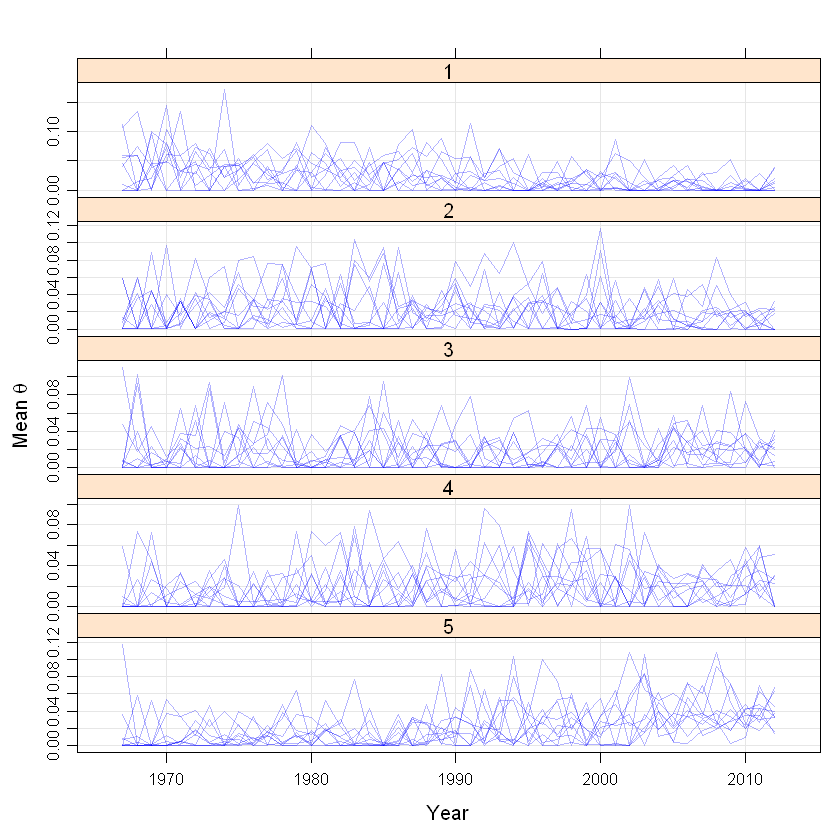

In [247]:
print(xyplot(theta_mean_by_year_ts[,names(sort(theta_mean_lm_coef_slope))],
	#layout = c(5, 5),
	#screens = c(rep("cold topics", 5), rep("hot topics", 5)),
	screens = rep(1:5, each = 10),
	superpose = TRUE,
	col = "blue",
	alpha = 0.3,
	#ylim = c(0, 0.015),
        #ylab = "Mean theta",
        ylab = expression(paste("Mean ",theta)),
	xlab = "Year",
	type = c("l", "g"),
	#aspect = "xy",
	#auto.key = list(space = "right"), 
	auto.key = FALSE,
	scales = list(x = list(alternating = FALSE)),
	#par.settings = standard.theme(color = FALSE)
	))

In [249]:
years <- levels(factor(mycorpus$anno))
topics_n <- lda@k
theta <- posterior(lda)$topics # theta is the per-document likelihood for a topic

In [250]:
theta_mean_by_year_by <- by(theta, mycorpus$anno, colMeans)
theta_mean_by_year <- do.call("rbind",theta_mean_by_year_by)
colnames(theta_mean_by_year) = paste(1:topics_n)

In [251]:
theta_mean_by_year_ts <- ts(theta_mean_by_year, start = as.integer(years[1]))
theta_mean_by_year_time <- time(theta_mean_by_year)

In [252]:
theta_mean_lm <- apply(theta_mean_by_year, 2, function(x) lm(x ~ theta_mean_by_year_time))
theta_mean_lm_coef <- lapply(theta_mean_lm, function(x) coef(summary(x)))
theta_mean_lm_coef_sign <- sapply(theta_mean_lm_coef, '[',"theta_mean_by_year_time","Pr(>|t|)")
theta_mean_lm_coef_slope <- sapply(theta_mean_lm_coef, '[',"theta_mean_by_year_time","Estimate")

In [253]:
theta_mean_lm_coef_slope_pos <- theta_mean_lm_coef_slope[theta_mean_lm_coef_slope >= 0]
theta_mean_lm_coef_slope_neg <- theta_mean_lm_coef_slope[theta_mean_lm_coef_slope < 0]

In [270]:
p_level <- c(0.5, 0.01, 0.001, 0.0001)
significance_total <- sapply(p_level, function(x) (theta_mean_lm_coef_sign[theta_mean_lm_coef_sign < x]))
significance_neg <- sapply(1:length(p_level), function(x) intersect(names(theta_mean_lm_coef_slope_neg), names(significance_total[[x]])))
significance_pos <- sapply(1:length(p_level), function(x) intersect(names(theta_mean_lm_coef_slope_pos), names(significance_total[[x]])))

In [271]:
significance_neg
significance_pos

[[1]]
 [1] "4"  "5"  "7"  "10" "12" "16" "17" "18" "25" "26" "30" "33" "40" "45" "50"

[[2]]
[1] "16" "18" "25" "26" "33" "50"

[[3]]
[1] "16" "25" "33"

[[4]]
[1] "16" "25" "33"

[[1]]
 [1] "1"  "2"  "9"  "13" "15" "20" "21" "22" "24" "27" "31" "35" "36" "37" "38"
[16] "39" "43" "47"

[[2]]
[1] "20" "21" "24" "31" "35" "36"

[[3]]
[1] "20" "24" "35" "36"

[[4]]
[1] "20" "35"

In [272]:
topics_hot <- as.numeric(names(sort(theta_mean_lm_coef_slope[significance_pos[[1]]], decreasing=TRUE)))
topics_cold <- as.numeric(names(sort(theta_mean_lm_coef_slope[significance_neg[[1]]], decreasing=FALSE)))

In [280]:
topics_hot
topics_cold

[1] 20 36 24 35 31 21

[1] 25 33 50 16 18 26

In [274]:
cold_and_hot_ts <- cbind(
    theta_mean_by_year_ts[,topics_cold[1:5]],
    theta_mean_by_year_ts[,topics_hot[1:5]], deparse.level=0)

In [275]:
colnames(cold_and_hot_ts) <- as.character(c(topics_cold[1:5], topics_hot[1:5]))

In [276]:
library(lattice)

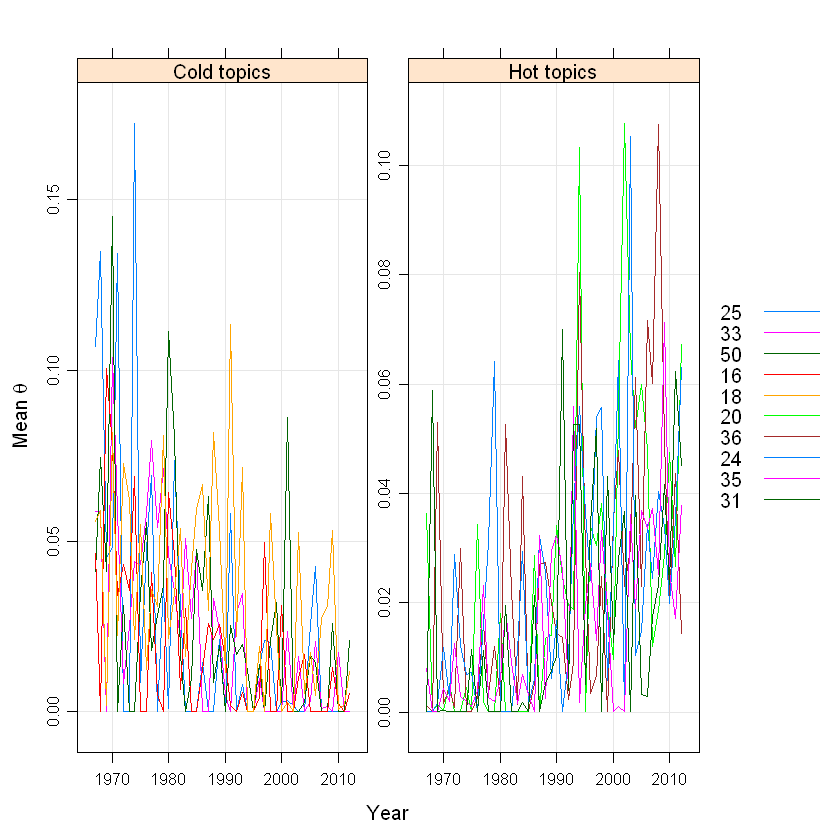

In [277]:
print(xyplot(cold_and_hot_ts,
	layout = c(2, 1),
        screens = c(rep("Cold topics", 5), rep("Hot topics", 5)),
	superpose = TRUE,
        #ylim = c(0.04, 0.06),
	ylab = expression(paste("Mean ",theta)),
	xlab = "Year",
	type = c("l", "g"),
	auto.key = list(space = "right"), 
	scales = list(x = list(alternating = FALSE))
    # scales= list( relation ="free")
	#par.settings = standard.theme(color = FALSE)
        ))

In [278]:
terms_10[c(topics_cold[1:5], topics_hot[1:5])]

Topic 25 
         "sects, religious, sect, social, churchsect, typology, development, along, organizations, face" 
                                                                                                Topic 33 
          "religious, experience, persons, experiences, reports, mystical, stress, values, found, study" 
                                                                                                Topic 50 
          "religious, religion, freedom, toward, related, study, paper, analysis, alienation, attitudes" 
                                                                                                Topic 16 
                 "belief, church, change, social, systems, data, found, religious, meaning, traditional" 
                                                                                                Topic 18 
                  "scale, factor, religious, study, scales, students, items, measure, analysis, factors" 
                                                                                                Topic 20 
           "religious, health, coping, religion, study, positive, life, negative, wellbeing, associated" 
                                                                                                Topic 36 
         "religious, participation, religion, study, effect, data, youth, women, society, socialization" 
                                                                                                Topic 24 
               "religious, states, united, religion, countries, study, levels, among, data, differences" 
                                                                                                Topic 35 
"beliefs, religious, belief, religion, study, environmental, paranormal, attitudes, scientific, society" 
                                                                                                Topic 31 
               "religious, age, social, protestant, cohort, church, effects, changes, study, attendance"

I do see some validity in this, for example mentions of "sects" have decreased over time. However theta is still quite erratic. The averaged topics in my thesis were a lot smoother (because of a bigger corpus and topics k), therefore the linear models made more sense.

A couple of suggestions:

- Try model fitting (maybe just rough manual k=10,20,30,40,50,70,...), to find optimal number of topics k for your analysis;

- possibly this takes care of common terms like "religious", "religion", otherwise try more pruning or stemming.

- For a better trend analysis maybe take a look at "dynamic topic models".